## Feed-forward Neural Network for Binary Classification
### Output layer implemented with sigmoid activation function and BCEWithLogitsLoss loss function
---

### Binary Cross Entropy Loss with Logits (BCEWithLogitsLoss)

\begin{align*}
\hspace{-10cm} p(y|\mathbf{x}) & =\sigma \Big(\mathbf{w}_2^T \left(\sigma (\mathsf{W}_1^T\mathbf{x}+\mathbf{b}_1)\right)+b_2\Big), \\
\hspace{-10cm} L(\mathbf{x}|y) & =-y\log(p(y|\mathbf{x}))-(1-y)\log(1-p(y|\mathbf{x})),
\end{align*}

where $y\in\{0, 1\}, $ $\mathsf{W}_1\in\mathbb{R}^{2\times 3}$ and $\mathbf{w}_2\in\mathbb{R}^{3\times 1}$ are the weights, $\mathbf{b}_1 \in\mathbb{R}^{3\times 1}$ and $b_2 \in \mathbb{R}^{1\times 1}$ are the biases. The activation function is the logistic sigmoid function.

Furthermore, assume $\mathsf{X} = (\mathbf{x}^{(0)}, ..., \mathbf{x}^{(n-1)})^T$, $\mathbf{y} = ({y}^{(0)}, ..., {y}^{(n-1)})^T$, $\mathsf{H} = (\mathbf{h}^{(0)}, ..., \mathbf{h}^{(n-1)})^T$, $\mathbf{p} = ({p}^{(0)}, ..., {p}^{(n-1)})^T$,  we can compute the $\frac{\partial \mathcal{L}_
\text{train}}{\partial \mathbf{w}_2}$, $\frac{\partial \mathcal{L}_
\text{train}}{\partial b_2}$, $\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}$, $\frac{\partial \mathcal{L}_
\text{train}}{\partial \mathsf{W}_1}$ and $\frac{\partial \mathcal{L}_\text{train}}{\partial \mathbf{b}_1}$ in a vectorized form (assume $\mathbf{1} \in \mathbb{R}^{n\times 1}$ is a $n$-dimenional vector where each entry is 1):

1. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathbf{w}_2} = \mathsf{H}^T \big(
    \mathbf{p}-\mathbf{y}\big)$.
2. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial {b}_2} = \mathbf{1}^T\big(
    \mathbf{p}-\mathbf{y}\big) $.
3. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathsf{H}} = \big(
    \mathbf{p}-\mathbf{y}\big) \mathbf{w}_2^T$ .
4. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathsf{W}_1} = \mathsf{X}^T\bigg(\big(\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}\big)\circ \mathsf{H}\circ (1-\mathsf{H})\bigg)$.
5. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial 
    \mathbf{b}_1} = \bigg(\big(\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}\big)\circ \mathsf{H}\circ (1-\mathsf{H})\bigg)^T \mathbf{1}$.


#### Load Data

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load original Iris dataset.
iris = datasets.load_iris()
old_X = iris.data
old_Y = iris.target

# Create the modified Iris dataset.
new_X = old_X[old_Y>0][:,2:]            # We only use last 2 features.
new_Y = old_Y[old_Y>0].reshape(-1,1)    # Use class 1,2 and convert 
new_Y[new_Y==1] = 0                    # them into class 0,1.
new_Y[new_Y==2] = 1        

# Generate training set and test set.
X_train =      np.vstack([new_X[:35],   new_X[50:85]])  # Shape: [70,2].
Y_train = np.concatenate([new_Y[:35],   new_Y[50:85]])  # Shape: [70,1].
X_test  =      np.vstack([new_X[35:50], new_X[85:100]]) # Shape: [30,2].
Y_test  = np.concatenate([new_Y[35:50], new_Y[85:100]]) # Shape: [30,1].

print(X_train.shape)     # X_train.shape should be (70,2), which shows 
                         # 70 training points where each has 2 features.
print(Y_train.shape)     # Y_train.shape should be (70,1) which shows 70 
print(np.unique(Y_train))# points where each point has label 0, 1.

(70, 2)
(70, 1)
[0 1]


#### Visualization of Original Data

In [29]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.utils import shuffle
import scipy.io as sio
plt.rcParams['figure.figsize'] = 8,8

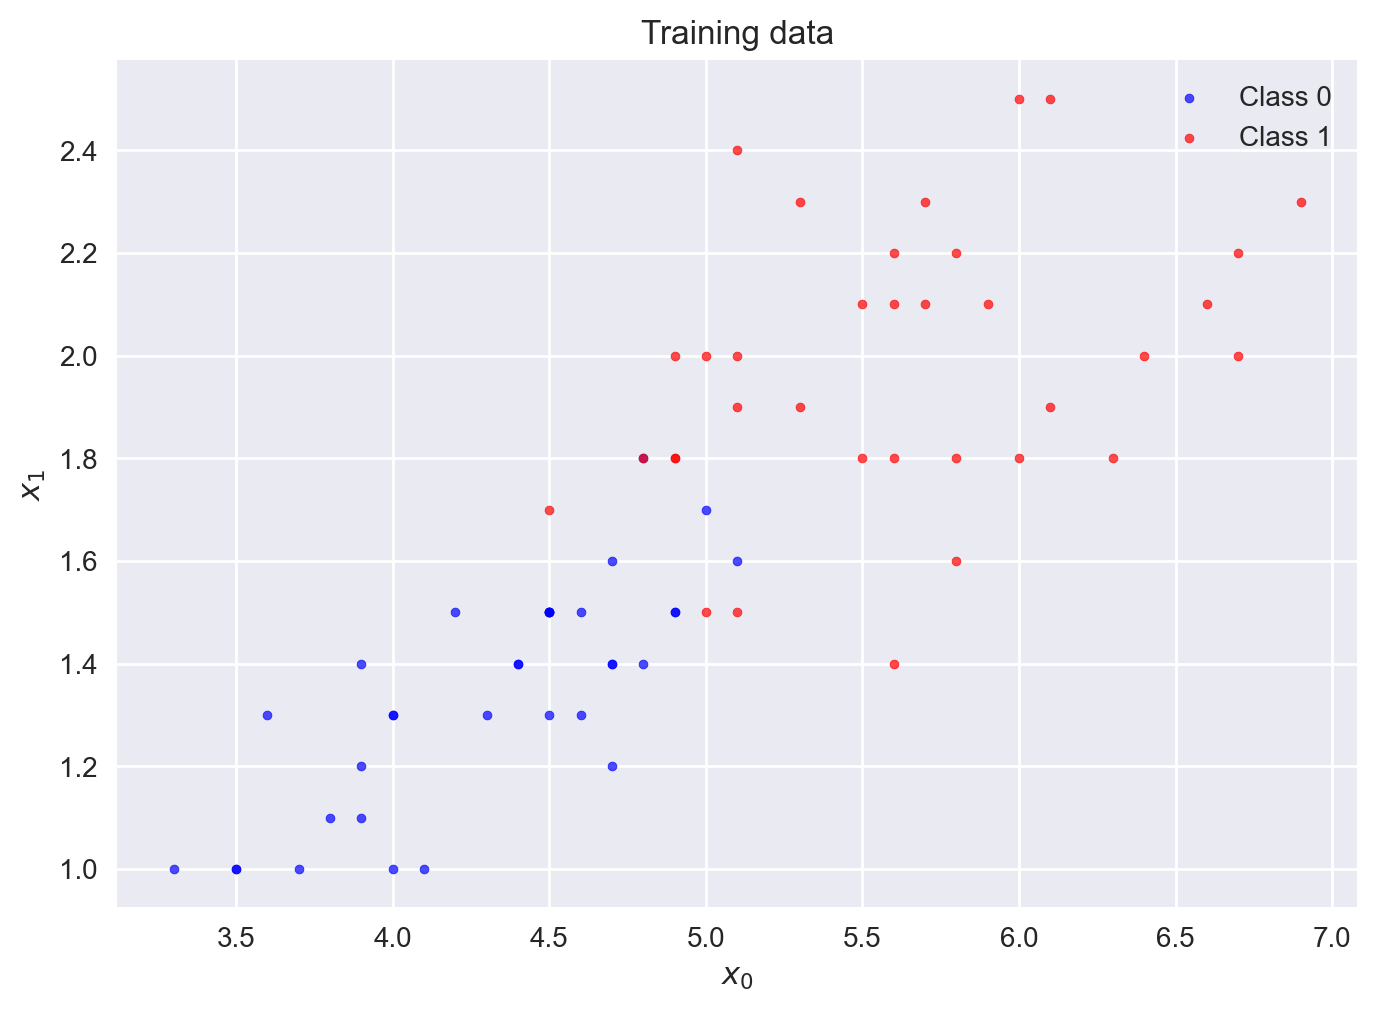

In [30]:
# Visualization of the training data.
plt.style.use("seaborn-v0_8")

fig = plt.figure()
plt.scatter(X_train[Y_train[:,0]==0, 0], 
            X_train[Y_train[:,0]==0, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==+1, 0], 
            X_train[Y_train[:,0]==+1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='upper right', fontsize=10)
plt.title('Training data')
plt.show()

#### Training Procedure

In [31]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [32]:
# Gradient of loss function: L'(W1, b1, W2, b2).
def L_prime(X, Y, W1, b1, W2, b2):
    """ L'(W,b) function. 
    X:  Feature matrix.    Shape: [n,2].
    Y:  Label vector.      Shape: [n,1].
    W1: Weight matrix W1.  Shape: [2,3].
    b1: Bias vector b1.    Shape: [3,1].
    W2: Weight matrix W2.  Shape: [3,1].
    b2: Bias vector b2.    Shape: [1,1].
    Return the gradients: dL/dW1 (Shape: [2,3]), dL/db1 (Shape: [3,1]),
                          dL/dW2 (Shape: [3,1]), dL/db2 (Shape: [1,1]).
    """
    # Get dimensions.
    n = X.shape[0]
    
    ####### Begin your code ######
    ## Calculate feed-forward values.
    H = sigmoid(X.dot(W1) + b1.T)                          # Shape: [n, 3].
    P = sigmoid((H.dot(W2) + b2))                            # Shape: [n, 1].
    
    ## Calculate the gradients: dL/dW1, dL/db1, dL/dW2, dL/db2.
    dL_by_dW2 = H.T.dot((P - Y))                             # Shape: [3,1].
    dL_by_db2 = np.ones([1, n]).dot(P - Y)                             # Shape: [1,1].
    dL_by_dH  = (P - Y).dot(W2.T)                             # Shape: [n,3].
    
    dL_by_dW1  = X.T.dot(dL_by_dH * (1 - H) * H)                            # Shape: [2,3].
    dL_by_db1  = (dL_by_dH * (1 - H) * H).T.dot(np.ones([n, 1]))                            # Shape: [3,1].
    ####### End your code ########
    
    # Return the gradients.
    return dL_by_dW1, dL_by_db1, dL_by_dW2, dL_by_db2

In [43]:
def L(X, Y, W1, b1, W2, b2):
    """ L(W,b) function. 
    X:  Feature matrix.    Shape: [n,2].
    Y:  Label vector.      Shape: [n,1].
    W1: Weight matrix W1.  Shape: [2,3].
    b1: Bias vector b1.    Shape: [3,1].
    W2: Weight matrix W2.  Shape: [3,1].
    b2: Bias vector b2.    Shape: [1,1].
    Return the loss.       Shape: Scalar.
    """
    # Get dimensions.
    n = X.shape[0]
    
    ####### Begin your code ######
    ## Calculate feed-forward values.
    H = sigmoid(X.dot(W1) + b1.T)                            # Shape: [n, 3].
    P = sigmoid((H.dot(W2) + b2))                            # Shape: [n, 1].
    
    ## Get the loss.
    L = -np.sum(Y * P + (1 - Y) * np.log(1 - P))                        # Shape: Scalar.
    
    ####### End your code ########
    
    return L

In [82]:
## The following codes might take a while to run, please be patient

learning_rate = 0.0015
n_iter = 400000                        # Number of iterations
np.random.seed(0)
W1 = np.random.randn(2,3)/((2*3)**2)   # Weight matrix 1.
b1 = np.random.randn(3,1)/((3*1)**2)   # Bias vector 1.
W2 = np.random.randn(3,1)/((3*1)**2)   # Weight matrix 2.
b2 = np.random.randn(1,1)/((1*1)**2)   # Bias vector 2.

# Xavier Initialization Variation
# W1 = np.random.randn(2,3) / np.sqrt(2)   # Weight matrix 1.
# b1 = np.zeros([3,1])   # Bias vector 1.
# W2 = np.random.randn(3,1) / np.sqrt(3)   # Weight matrix 2.
# b2 = np.zeros([1,1])   # Bias vector 2.

# We will keep track of training loss over iterations.
iterations = [0]
print(L(X_train, Y_train, W1, b1, W2, b2))
L_list = [L(X_train, Y_train, W1, b1, W2, b2)]
for i in range(n_iter):
    ####### Begin your code ######
    ## Calculate current gradients
    gradient_W1, gradient_b1, gradient_W2, gradient_b2 = L_prime(X_train, Y_train, W1, b1, W2, b2)
    
    ## Perform gradient descent
    W1_new = W1 - learning_rate * gradient_W1
    b1_new = b1 - learning_rate * gradient_b1
    W2_new = W2 - learning_rate * gradient_W2
    b2_new = b2 - learning_rate * gradient_b2
    ####### End your code ########
    
    iterations.append(i+1)
    L_list.append(L(X_train, Y_train, W1_new, b1_new, W2_new, b2_new))
    
    # L1-norm of weight/bias changing.
    norm = np.abs(W1_new-W1).sum() + np.abs(b1_new-b1).sum() + \
           np.abs(W2_new-W2).sum() + np.abs(b2_new-b2).sum() 
    
    if i%40000 == 0 or i+1 == n_iter:
        print('i: {:6d} L: {:.3f} norm:{:.6f}'.format(i, L_list[-1], norm))
        
    W1 = W1_new
    b1 = b1_new
    W2 = W2_new
    b2 = b2_new
    
print ('W1 matrix: \n' + str(W1))
print ('b1 vector: \n' + str(b1))
print ('W2 matrix: \n' + str(W2))
print ('b2 vector: \n' + str(b2))

18.196699184522746
i:      0 L: 17.483 norm:0.063199
i:  40000 L: -26.998 norm:0.000205
i:  80000 L: -27.030 norm:0.000199
i: 120000 L: -27.757 norm:0.000997
i: 160000 L: -29.698 norm:0.000667
i: 200000 L: -30.222 norm:0.000415
i: 240000 L: -30.476 norm:0.000322
i: 280000 L: -30.639 norm:0.000269
i: 320000 L: -30.760 norm:0.000233
i: 360000 L: -30.859 norm:0.000207
i: 399999 L: -30.943 norm:0.000187
W1 matrix: 
[[ -9.07941339   0.14517877   4.69028432]
 [ 15.37991023 -12.58218362 -18.15317158]]
b1 vector: 
[[21.87635203]
 [15.40768077]
 [ 8.01694418]]
W2 matrix: 
[[-22.28338952]
 [-17.01756196]
 [-15.88891876]]
b2 vector: 
[[26.23650978]]


#### Training Loss Curve

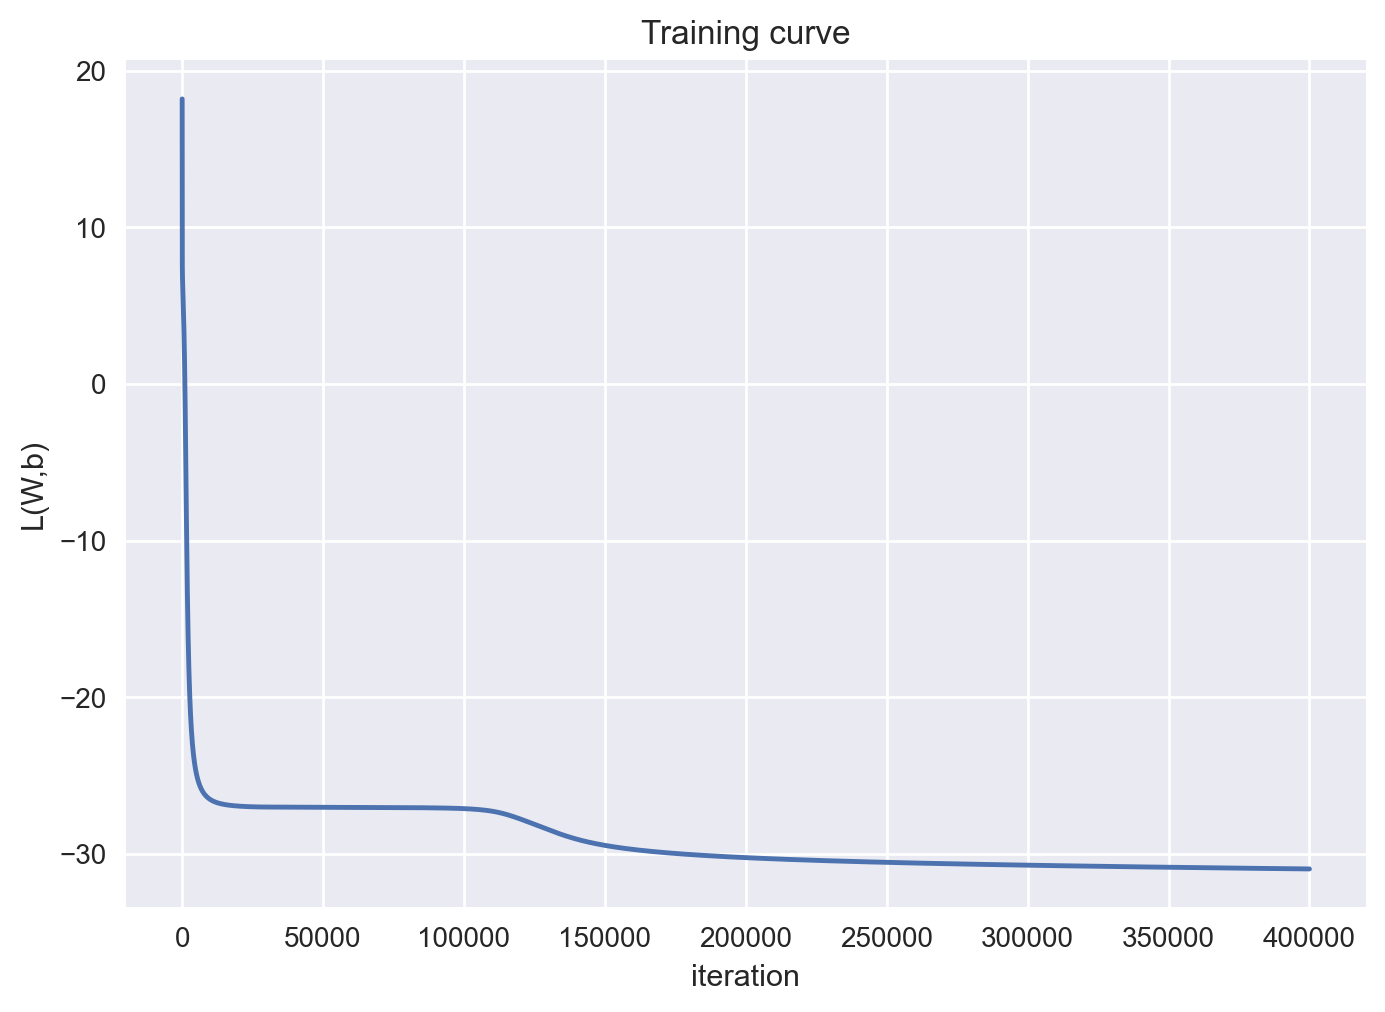

In [83]:
plt.title('Training curve')
plt.xlabel('iteration')
plt.ylabel('L(W,b)')
# plt.semilogy(iterations, np.array(L_list).reshape(-1, 1))
plt.plot(iterations, L_list) 
plt.show()

#### Results on Training Data

In [84]:
# Prepare for decision boundary.
num = 100
X0_plane_range = np.linspace(1,7,num)
X1_plane_range = np.linspace(0,2.5,num)
X0_plane, X1_plane = np.meshgrid(X0_plane_range, X1_plane_range)
X_decision = np.stack([X0_plane.reshape(-1), X1_plane.reshape(-1)]).T

# Calculate feed-forward values.
f_decision = sigmoid(X_decision.dot(W1)+b1.T).dot(W2)+b2.T # Shape: [n,1].
yhat_decision = np.ones_like(f_decision)  # Define yhat_decision as an array of zeros with the same shape as f_decision.
yhat_decision[f_decision<0] = 0

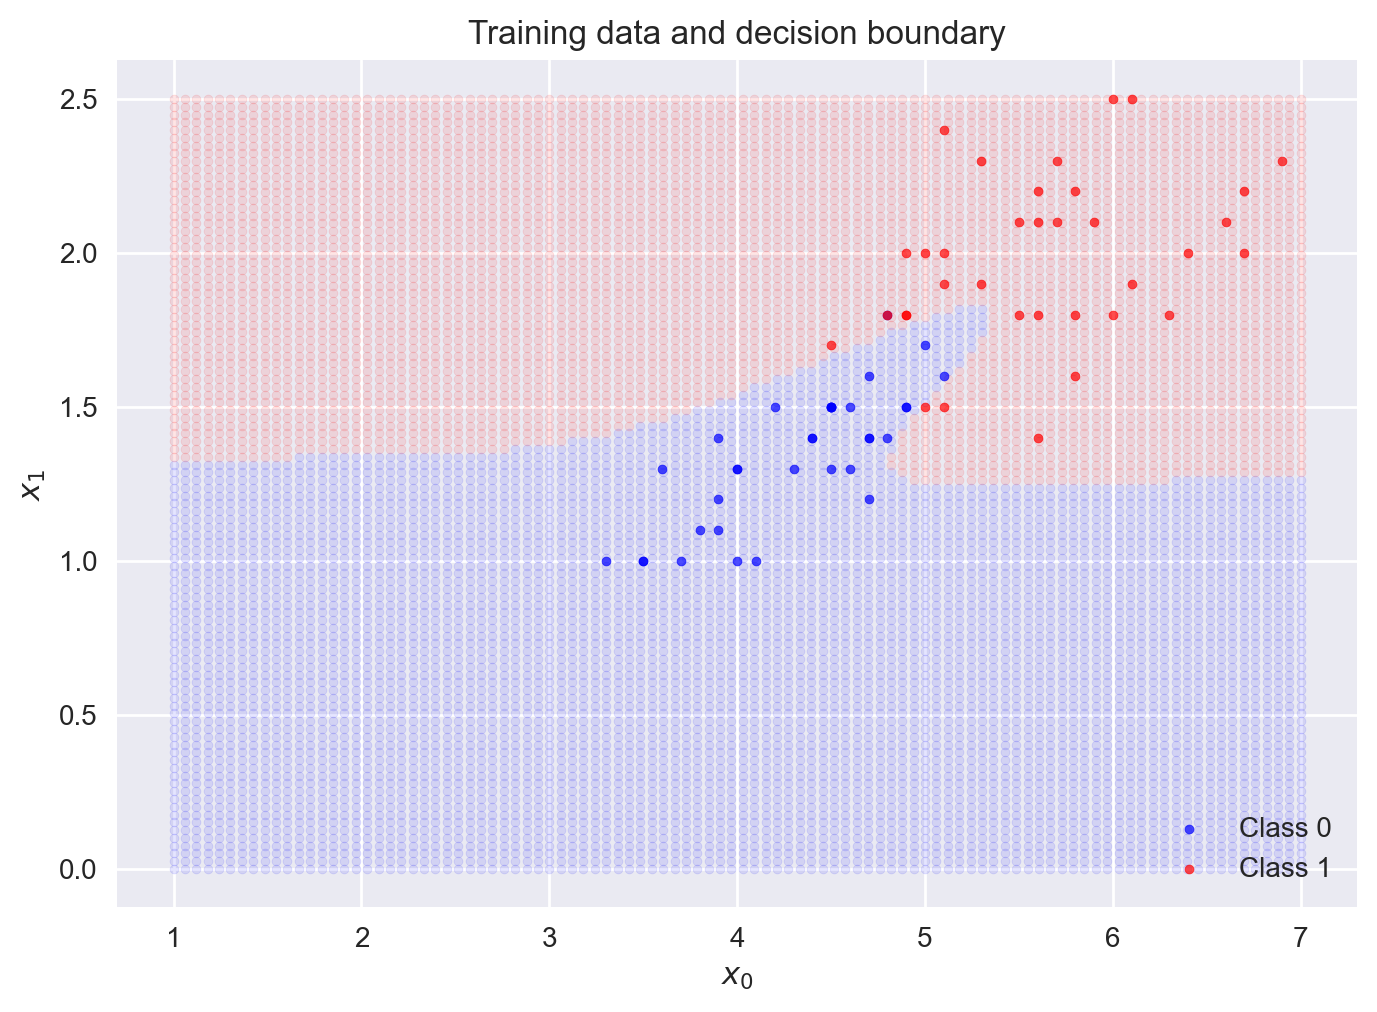

In [85]:
# Training data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==0, 0], 
            X_decision[yhat_decision[:,0]==0, 1], 
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0], 
            X_decision[yhat_decision[:,0]==1, 1], 
            marker='o', color='r', alpha=0.1, s=10)

plt.scatter(X_train[Y_train[:,0]==0, 0], 
            X_train[Y_train[:,0]==0, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==1, 0], 
            X_train[Y_train[:,0]==1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

In [86]:
# Calculate the test error.
f_train = sigmoid(X_train.dot(W1)+b1.T).dot(W2)+b2.T  # Shape: [n,1].
yhat_train = np.sign(f_train)
train_error = 1 - np.sum(yhat_train == Y_train) / Y_train.shape[0]
print('Train error: {}'.format(train_error))

Train error: 0.5


#### Results on Test Data

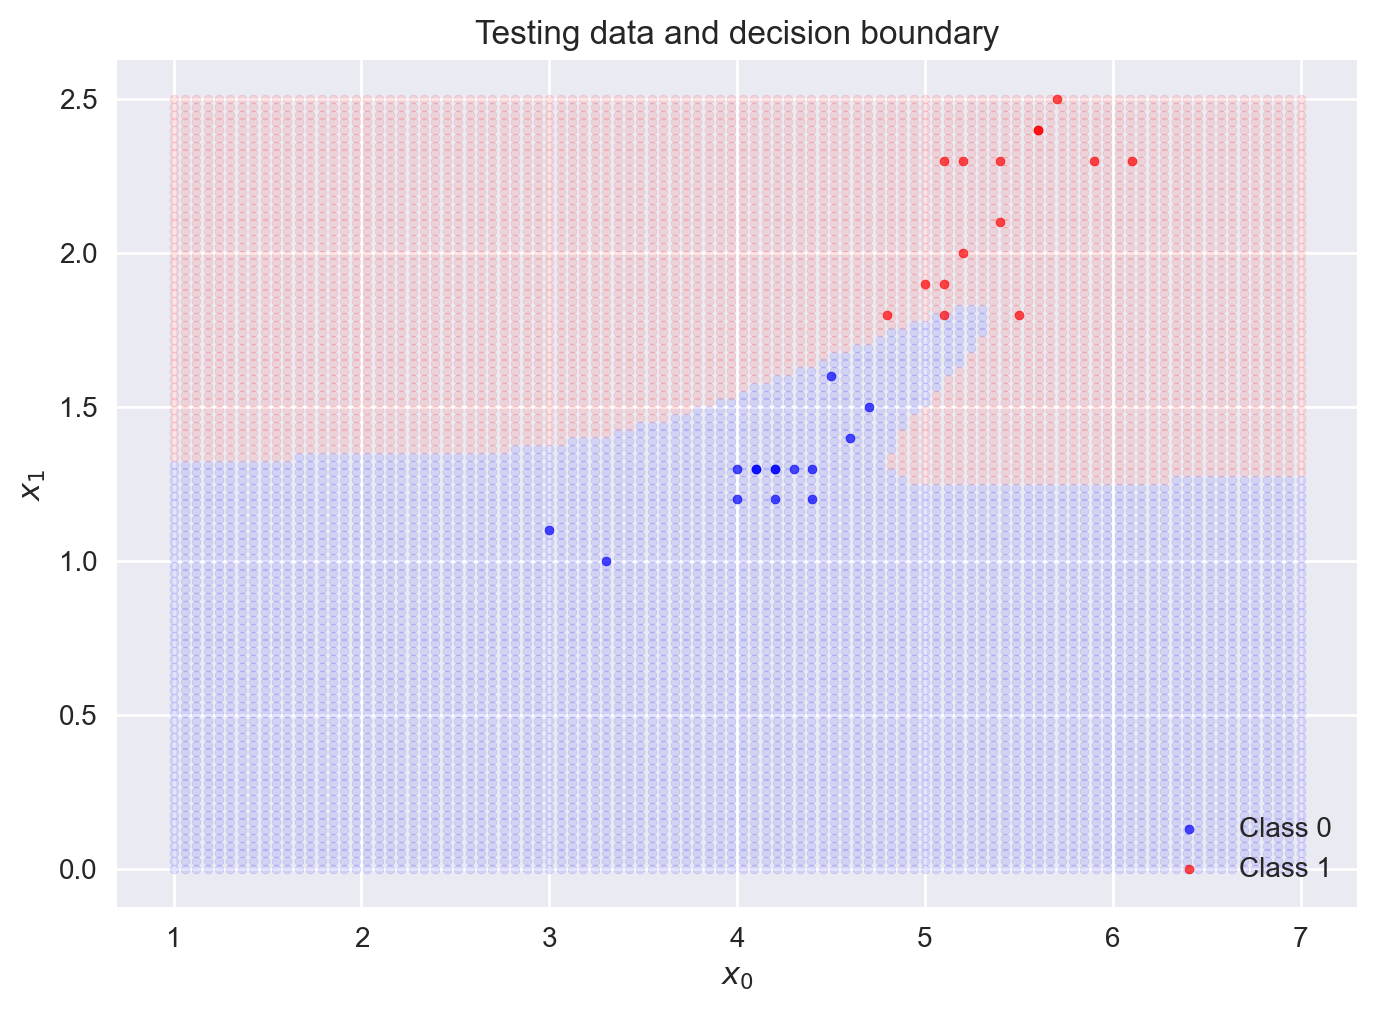

In [87]:
# Test data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==0, 0], 
            X_decision[yhat_decision[:,0]==0, 1], 
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0], 
            X_decision[yhat_decision[:,0]==1, 1], 
            marker='o', color='r', alpha=0.1, s=10)

plt.scatter(X_test[Y_test[:,0]==0, 0], 
            X_test[Y_test[:,0]==0, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_test[Y_test[:,0]==1, 0], 
            X_test[Y_test[:,0]==1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Testing data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

In [88]:
# Calculate the test error.
f_test = sigmoid(X_test.dot(W1)+b1.T).dot(W2)+b2.T  # Shape: [n,1].
yhat_test = np.sign(f_test)
test_error = 1 - np.sum(yhat_test == Y_test) / Y_test.shape[0]
print('Test error: {}'.format(test_error))

Test error: 0.5333333333333333
